# Get a LSST Simulated Cadence for Arbitrary Sky Position
___


___

In [40]:
"""

"""
# %matplotlib inline
%matplotlib notebook


from __future__ import print_function

try:
    from importlib import reload
except:
    pass


from matplotlib import pyplot as plt
import matplotlib.colors as mpl_colors 
from matplotlib import colorbar as mpl_colorbar
from matplotlib import rc
rc('text', usetex=True)

import os
import warnings

import numpy as np
import pandas as pd
import astropy as ap
import sfdmap

import sqlite3
from sqlalchemy import create_engine

from astropy import units as u
from astropy.coordinates import SkyCoord

import lsst_tools.utils as utils 
import lsst_tools.utils.colours as colours 

from multiprocessing import Pool, cpu_count
from contextlib import closing

Connect to .db file that contains the opsim output, read into a dataframe, `opsimdf`

In [2]:
# %%timeit ## 1 loop, best of 3: 1min 31s per loop 
# opsimdbpath = os.environ.get('OPSIMDBPATH')
# print(opsimdbpath)
opsimdbpath = "/Users/berto/data/LSST/OpSimOutputDBs/astro_lsst_01_1068_sqlite.db"

conn = create_engine('sqlite:///'+opsimdbpath, echo = False)
opsimdf = pd.read_sql_table('Summary', con=conn)

In [3]:
opsimdf

,obsHistID,sessionID,propID,fieldID,fieldRA,fieldDec,filter,expDate,expMJD,night,...,moonBright,darkBright,rawSeeing,wind,humidity,slewDist,slewTime,fiveSigmaDepth,ditheredRA,ditheredDec
0,1,1068,227,505,1.720374,-0.936476,y,2922,59580.033829,0,...,0.000000,105.043185,0.920473,0.0,0.0,1.659226,0.000000,21.013506,1.694604,-0.962927
1,2,1068,227,567,1.648235,-0.903353,y,2961,59580.034278,0,...,0.000000,101.373243,0.920473,0.0,0.0,0.054827,4.769109,21.058304,1.623562,-0.929804
2,3,1068,227,561,1.563788,-0.915583,y,3000,59580.034726,0,...,0.000000,98.042992,0.920473,0.0,0.0,0.053275,4.780469,21.099047,1.538724,-0.942034
3,4,1068,227,539,1.477422,-0.924531,y,3039,59580.035175,0,...,0.000000,95.139389,0.920473,0.0,0.0,0.053066,4.762092,21.134714,1.452062,-0.950982
4,5,1068,227,531,1.389669,-0.930365,y,3077,59580.035623,0,...,0.000000,92.619319,0.920473,0.0,0.0,0.052952,4.739055,21.165823,1.364111,-0.956816
5,6,1068,227,517,1.301075,-0.933239,y,3116,59580.036071,0,...,0.000000,90.448151,0.920473,0.0,0.0,0.052904,4.709074,21.192773,1.275418,-0.959690
6,7,1068,227,519,1.212198,-0.933238,y,3155,59580.036519,0,...,0.000000,88.596990,0.920473,0.0,0.0,0.052892,4.669665,21.215880,1.186541,-0.959689
7,8,1068,227,523,1.123604,-0.930366,y,3193,59580.036967,0,...,0.000000,87.040118,0.920473,0.0,0.0,0.052904,4.742319,21.235417,1.098046,-0.956817
8,9,1068,227,541,1.035849,-0.924530,y,3233,59580.037422,0,...,0.000000,85.753276,0.920473,0.0,0.0,0.052953,5.250509,21.251646,1.010489,-0.950981
9,10,1068,227,698,0.988892,-0.827713,y,3272,59580.037880,0,...,0.000000,83.013952,0.920473,0.0,0.0,0.101357,5.588682,21.286460,0.966319,-0.854164


In [4]:
len(opsimdf["fieldID"].unique())

3339

In [5]:
#%%timeit ## The slowest run took 39.04 times longer than the fastest. This could mean that an intermediate result is being cached.
#         ## 1000 loops, best of 3: 246 µs per loop
n = 1
pos_df = utils.generate_coordinates(n)

Add extinction to the dataframe

In [6]:
#%%timeit ## 1 loop, best of 3: 88.6 ms per loop
df = utils.find_MW_extinction(pos_df) 

Check the positions are sensible

<IPython.core.display.Javascript object>


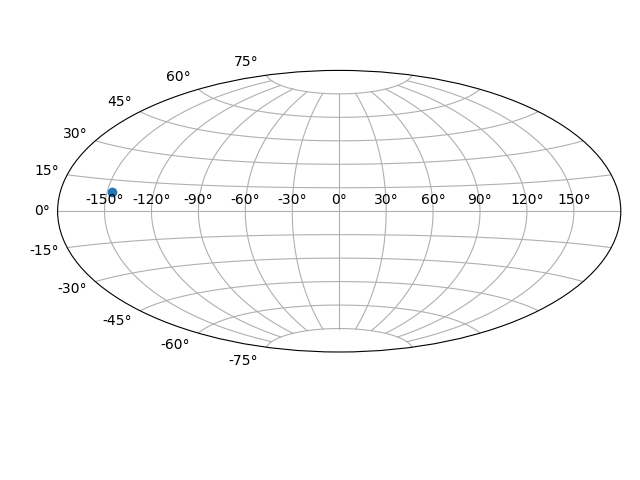

In [7]:
#%%timeit ## 1 loop, best of 3: 235 ms per loop
utils.plot_position_points(df)

Connecting to `.db` takes ages (~1min), and is a pain if you mess up, so create a 'working' instance to fiddle with

In [9]:
working_df = opsimdf

## Identifying Fields
___
We want to find out which field(s) the position is in. Create table that tells us the field centres, and find the edges.

In [10]:
# working_df = utils.get_field_corners(working_df.drop_duplicates("fieldID"))[['fieldRA', 'fieldDec']]
working_df = utils.get_field_corners(pd.DataFrame(working_df.drop_duplicates("fieldID"))[['fieldID', 'fieldRA', 'fieldDec']])

In [11]:
working_df

,fieldID,fieldRA,fieldDec,RA_upper,RA_lower,Dec_upper,Dec_lower
0,505,1.720374,-0.936476,1.750917,1.689831,-0.967019,-0.905933
1,567,1.648235,-0.903353,1.678778,1.617692,-0.933896,-0.872810
2,561,1.563788,-0.915583,1.594331,1.533245,-0.946126,-0.885040
3,539,1.477422,-0.924531,1.507965,1.446879,-0.955074,-0.893988
4,531,1.389669,-0.930365,1.420212,1.359126,-0.960908,-0.899822
5,517,1.301075,-0.933239,1.331618,1.270532,-0.963782,-0.902696
6,519,1.212198,-0.933238,1.242741,1.181655,-0.963781,-0.902695
7,523,1.123604,-0.930366,1.154147,1.093061,-0.960909,-0.899823
8,541,1.035849,-0.924530,1.066392,1.005306,-0.955073,-0.893987
9,698,0.988892,-0.827713,1.019435,0.958349,-0.858256,-0.797170


In [12]:
field_df = working_df[(working_df["RA_upper"] >= df["theta"][0] + np.pi) &
                (working_df["RA_lower"] <= df["theta"][0] + np.pi) &
                (working_df["Dec_lower"] >= df["phi"][0])  &
                (working_df["Dec_upper"] <= df["phi"][0])]

<IPython.core.display.Javascript object>


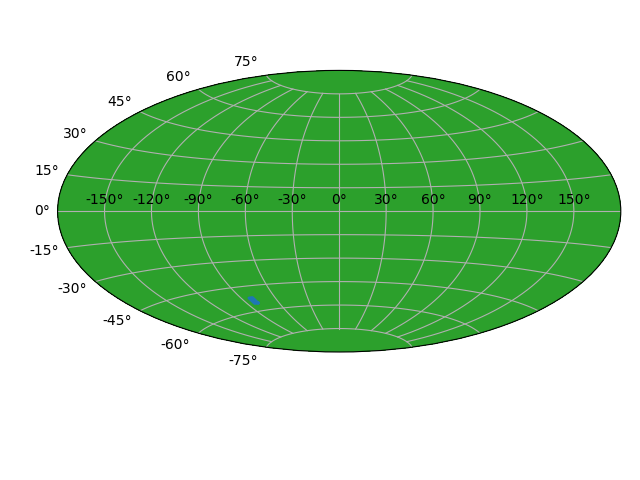

In [13]:
reload(utils)
utils.plot_field(working_df)

In [14]:
df = opsimdf

In [15]:
## Work out how often each field is visited
min_visits = df["fieldID"].value_counts().min()
max_visits = df["fieldID"].value_counts().max()

print(min_visits, ",",max_visits)

df['count'] = df.groupby('fieldID').cumcount()

180 , 23271


In [16]:
ddf = [1427,744,2412,290,2786  ]

In [17]:
cmap = plt.get_cmap("viridis")
# df["cmap_visit_value"] = (df["count"] - min_visits )/(max_visits - min_visits)
df["cmap_visit_value"] = np.log((df["count"] + 1)/(max_visits+1))

In [18]:
df["cmap_visit_value"] = df["cmap_visit_value"] + np.abs(df["cmap_visit_value"].min())
df["cmap_visit_value"] = df["cmap_visit_value"]/df["cmap_visit_value"].max()

In [19]:
df["cmap_visit_value"].hist(bins = 200)

In [20]:
df["fieldID"].value_counts().hist(bins = 200, range = [0, 2000])

In [21]:
df = utils.get_field_corners(df)

In [22]:
night_group = df.groupby("night")

In [23]:
#TEST
# i = 0
# group = night_group.groups[0]
# outpath = "/Users/berto/plots/LSST/cadence/minion/skymap_night_"
# fig = plt.figure()
# fig.subplots_adjust(left = 0.09, bottom = 0.13, top = 0.99,
#                     right = 0.97, hspace=0, wspace = .1)

# ax_aitoff = fig.add_subplot(111, projection="aitoff")
# ax_aitoff.grid(True)
# ax_aitoff.scatter(df["fieldRA"][group] - np.pi, df["fieldDec"][group], color = cmap(df["cmap_visit_value"][group]))
# fig.savefig(outpath + str(i)+".pdf", format = 'pdf', dpi=500)
# plt.close()

In [24]:
# for group in night_group.groups:
#     print(night_group.groups[0])

In [25]:
df_to_plot = df[["fieldID", "fieldRA", "fieldDec", "cmap_visit_value"]]
df_to_plot["zorder"] = df_to_plot["fieldID"]*0
df_to_plot["zorder"].loc[df_to_plot["fieldID"].isin(ddf)] = 99

/Users/berto/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/berto/anaconda2/envs/py3/lib/python3.6/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/berto/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/sta

In [26]:
df_to_plot.loc[night_group.groups[0]]

,fieldID,fieldRA,fieldDec,cmap_visit_value,zorder
0,505,1.720374,-0.936476,0.000000,0
1,567,1.648235,-0.903353,0.000000,0
2,561,1.563788,-0.915583,0.000000,0
3,539,1.477422,-0.924531,0.000000,0
4,531,1.389669,-0.930365,0.000000,0
5,517,1.301075,-0.933239,0.000000,0
6,519,1.212198,-0.933238,0.000000,0
7,523,1.123604,-0.930366,0.000000,0
8,541,1.035849,-0.924530,0.000000,0
9,698,0.988892,-0.827713,0.000000,0


In [27]:
x = len(night_group.groups)

In [28]:
str('%05d' % x)

'03020'

In [29]:
df_to_plot

,fieldID,fieldRA,fieldDec,cmap_visit_value,zorder
0,505,1.720374,-0.936476,0.000000,0
1,567,1.648235,-0.903353,0.000000,0
2,561,1.563788,-0.915583,0.000000,0
3,539,1.477422,-0.924531,0.000000,0
4,531,1.389669,-0.930365,0.000000,0
5,517,1.301075,-0.933239,0.000000,0
6,519,1.212198,-0.933238,0.000000,0
7,523,1.123604,-0.930366,0.000000,0
8,541,1.035849,-0.924530,0.000000,0
9,698,0.988892,-0.827713,0.000000,0


In [30]:
# def plot_obs(df):
#     outpath = "/Users/berto/plots/LSST/cadence/minion/Test_skymap_night_"

#     df_to_plot = df[["fieldID", "fieldRA", "fieldDec", "cmap_visit_value"]]
#     df_to_plot["zorder"] = df_to_plot["fieldID"]*0
#     df_to_plot["zorder"].loc[df_to_plot["fieldID"].isin(ddf)] = 99

#     norm = mpl_colors.LogNorm(vmin=max_visits, vmax=min_visits)


#     for i, group in enumerate(np.arange(10)):
#     # for i, group in enumerate(night_group.groups):

#         if i == 0:
#             fig = plt.figure()
#             fig.subplots_adjust(left = 0.09, bottom = 0.13, top = 0.99,
#                                 right = 0.97, hspace=0, wspace = .1)

#     #         ax_aitoff = fig.add_subplot(111, projection="aitoff")      
#             ax_aitoff = plt.subplot2grid((1,24), (0,0), colspan = 22, rowspan = 1, projection="aitoff")
#             ax_aitoff.grid(True)
#             ax_cbar = plt.subplot2grid((1,24), (0,22), colspan = 1, rowspan = 1)
#     #         ax_active = fig.add_subplot(111, projection="aitoff")


#             working_df_to_plot = df_to_plot.loc[night_group.groups[group]]
#         else:
#             working_df_to_plot = pd.concat([working_df_to_plot,df_to_plot.loc[night_group.groups[group]]])
#             working_df_to_plot.drop_duplicates(subset=['fieldID'], inplace=True, keep="last")

#     #     ax_aitoff.scatter(working_df_to_plot["fieldRA"][night_group.groups[group]] - np.pi, 
#     #               working_df_to_plot["fieldDec"][night_group.groups[group]], 
#     #               color = cmap(working_df_to_plot["cmap_visit_value"][night_group.groups[group]]))

#         ax_aitoff.scatter(working_df_to_plot["fieldRA"] - np.pi, 
#                           working_df_to_plot["fieldDec"], 
#                           color = cmap(working_df_to_plot["cmap_visit_value"]))

#         ax_aitoff.scatter(working_df_to_plot.loc[df_to_plot["zorder"] == 99,["fieldRA"]] - np.pi, 
#                           working_df_to_plot.loc[df_to_plot["zorder"] == 99,["fieldDec"]], 
#                           color = cmap(working_df_to_plot[working_df_to_plot["zorder"] == 99]["cmap_visit_value"])
#                           )

#     #     fig_cont = fig

#     #     ax_active.scatter(working_df_to_plot["fieldRA"] - np.pi, 
#     #                       working_df_to_plot["fieldDec"], 
#     #                       color = cmap(working_df_to_plot["cmap_visit_value"]),
#     #                       linewidths = 0.5 , edgecolors = colours.hex["black"])

#         cb1 = mpl_colorbar.ColorbarBase(ax_cbar, cmap=cmap,
#                                     norm=norm)
#         fig.savefig(outpath + str('%05d' % i)+".png", format = 'png', dpi=200)

#     #     ax_active.clear()
#     #     print(len(working_df_to_plot))
#     # plt.close()

In [ ]:
df_to_plot = df[["fieldID", "fieldRA", "fieldDec", "cmap_visit_value"]]

# outpath = "/Users/berto/plots/LSST/cadence/minion/Test_skymap_night_"
outpath = "/Users/berto/plots/LSST/cadence/minion/skymap_night_"

df_to_plot["zorder"] = df_to_plot["fieldID"]*0
df_to_plot["zorder"].loc[df_to_plot["fieldID"].isin(ddf)] = 99
norm = mpl_colors.LogNorm(vmin=max_visits, vmax=min_visits)


# for i, group in enumerate(np.arange(4)):
for i, group in enumerate(night_group.groups):

    if i == 0:
        fig = plt.figure()
        fig.subplots_adjust(left = 0.05, bottom = 0.05, top = 0.99,
                            right = 0.97, hspace=0, wspace = .1)
    
#         ax_aitoff = plt.subplot2grid((1,24), (0,0), colspan = 22, rowspan = 1, projection="aitoff")
#         ax_aitoff.grid(True)
#         ax_active = plt.subplot2grid((1,24), (0,0), colspan = 22, rowspan = 1, projection="aitoff")
#         ax_active.grid(True)
    
        ax_aitoff = fig.add_subplot(111, projection = "aitoff")
        ax_active = fig.add_subplot(111, projection = "aitoff")
        ax_aitoff.grid(True)
        ax_active.grid(True)

#         ax_cbar = plt.subplot2grid((1,24), (0,22), colspan = 1, rowspan = 1)
        ax_cbar = fig.add_subplot(20,1,19)
        cb1 = mpl_colorbar.ColorbarBase(ax_cbar, cmap=cmap,
                                norm=norm, orientation='horizontal')
        cb1.set_label(r'$\textnormal{Number of Visits}$')
        
        working_df_to_plot = df_to_plot.loc[night_group.groups[group]]

    else:
#         ax_active = fig.add_subplot(111, projection = "aitoff")
        working_df_to_plot = pd.concat([working_df_to_plot,df_to_plot.loc[night_group.groups[group]]])
    
        working_df_to_plot.drop_duplicates(subset=['fieldID'], inplace=True, keep="last")

    s1 = ax_aitoff.scatter(working_df_to_plot["fieldRA"] - np.pi, 
                      working_df_to_plot["fieldDec"], 
                      color = cmap(working_df_to_plot["cmap_visit_value"]))

    
    s2 = ax_aitoff.scatter(working_df_to_plot.loc[df_to_plot["zorder"] == 99,["fieldRA"]] - np.pi, 
                      working_df_to_plot.loc[df_to_plot["zorder"] == 99,["fieldDec"]], 
                      color = cmap(working_df_to_plot[working_df_to_plot["zorder"] == 99]["cmap_visit_value"])
                      )
    
    s_a = ax_active.scatter(df_to_plot.loc[night_group.groups[group]]["fieldRA"] - np.pi, 
                      df_to_plot.loc[night_group.groups[group]]["fieldDec"], 
                      color = cmap(df_to_plot.loc[night_group.groups[group]]["cmap_visit_value"]),
                      edgecolor = colours.hex["black"])

    ## Works
#     s1 = ax_aitoff.scatter(x, data[str(group)], color = colours.hex["pomegranite"])
#     s_a = ax_active.scatter(x, data[str(group)], color = colours.hex["pomegranite"], edgecolor = "black")
    
    ## Works
#     s1 = ax_aitoff.scatter(working_df_to_plot["fieldRA"] - np.pi, 
#                            working_df_to_plot["fieldDec"], 
#                       color = colours.hex["pomegranite"])

#     s_a = ax_active.scatter(df_to_plot.loc[night_group.groups[group]]["fieldRA"] - np.pi, 
#                       df_to_plot.loc[night_group.groups[group]]["fieldDec"], 
#                       color = colours.hex["pomegranite"],
#                       edgecolor = colours.hex["black"])
#     print(len(working_df_to_plot["fieldDec"]))
    plt.draw()
    fig.savefig(outpath + str('%05d' % i)+".png", format = 'png', dpi=200)
    s_a.remove()
#     del(s_a)
    
#     fig.delaxes(ax_active)


/Users/berto/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/berto/anaconda2/envs/py3/lib/python3.6/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/berto/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-co

<IPython.core.display.Javascript object>

In [ ]:
ones = np.ones(10)

In [ ]:
len(ones[0:])

In [ ]:
working_df_to_plot[working_df_to_plot["zorder"] == 99]["cmap_visit_value"]

In [ ]:
df_to_plot.loc[df_to_plot["zorder"] == 99,["fieldRA"]]

In [ ]:
# working_df_to_plot["fieldID"] in df_to_plot["fieldID"]
# df1 = working_df_to_plot.head(10)
# df2 = working_df_to_plot.tail(10)
df1 = df_to_plot.loc[df_to_plot["fieldID"] == 505].head(1)
df2 = df_to_plot.loc[df_to_plot["fieldID"] == 505].tail(1)

In [ ]:
df_to_plot["zorder"].loc[df_to_plot["fieldID"].isin(ddf)] = 1

In [ ]:
df_to_plot["zorder"].loc[df_to_plot["fieldID"].isin(ddf)]

In [ ]:
df2

In [ ]:
df1

In [ ]:
df3 = pd.concat([df1,df2])

In [ ]:
df3

In [ ]:
df3.drop_duplicates(subset=['fieldID'], inplace=True, keep="last")

In [ ]:
df3

In [ ]:
df.loc[df["fieldID"] == 505].head(10)

In [ ]:
# outpath = "/Users/berto/plots/LSST/cadence/minion/skymap_"


# for row in df.iterrows():
#     fig = plt.figure()
#     fig.subplots_adjust(left = 0.09, bottom = 0.13, top = 0.99,
#                         right = 0.97, hspace=0, wspace = .1)

#     ax_aitoff = fig.add_subplot(111, projection="aitoff")
#     ax_aitoff.grid(True)
#     ax_aitoff.scatter(row["fieldRA"] - np.pi, row["fieldDec"], color = cmap(row[cmap_visit_value]))
    
#     fig.savefig(outpath + row["obsHistID"]+".pdf", format = 'pdf', dpi=500)

In [ ]:
data = {}
x = np.arange(10)

for i in np.arange(5):
    data[str(i)] = np.random.random(10)

outpath = "/Users/berto/plots/LSST/cadence/test_"

for i, j in enumerate(data):
    if i == 0:
        fig = plt.figure()
        fig.subplots_adjust(left = 0.05, bottom = 0.01, top = 0.99,
                            right = 0.97, hspace=0, wspace = .1)

        ax = fig.add_subplot(111, projection = "aitoff")
        ax_active = fig.add_subplot(111, projection = "aitoff")
        
    else:
        pass
    
    s1 = ax.scatter(x, data[j], color = colours.hex["pomegranite"])
    s2 = ax_active.scatter(x, data[j], color = colours.hex["pomegranite"], edgecolor = "black")
    
    fig.savefig(outpath + str('%05d' % i)+".png", format = 'png', dpi=200)
    s2.remove()
